In [3]:
import re
import pandas as pd
import numpy as np
import scipy as sc
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3

from sklearn.preprocessing import StandardScaler

In [4]:
mutants = pd.read_csv('data/cleank8.csv', header=None, low_memory=False)

In [5]:
nametags = mutants[5408].astype(str)
print(nametags)

0              a119e_l125p
1        a119e_r283k_a353v
2                    c135y
3              c135y_e285m
4              c135y_e285v
               ...        
16586    y220c_t230c_n239y
16587    y220c_y234f_n239l
16588                y234c
16589          y234c_a119e
16590          y234f_n239l
Name: 5408, Length: 16591, dtype: object


In [6]:
singles = [] # one mutation
doubles = [] # two mutations
triples = [] # three mutations
multis = [] # four or more mutations

In [7]:
for tag in nametags:
        search = re.findall('[0-9]+', str(tag))
        snps = np.array(list(map(int, search)))
        num_loci = len(snps)
        
        if num_loci == 1:
            #t = nametags.index(nametags.loc[tag])
            singles.append(mutants[mutants[5408] == tag])
        elif num_loci == 2:
            #t = nametags.index(tag)
            doubles.append(mutants[mutants[5408] == tag])
        elif num_loci == 3:
            #t = nametags.index(tag)
            triples.append(mutants[mutants[5408] == tag])
        elif num_loci >= 4:
            #t = nametags.index(tag)
            multis.append(mutants[mutants[5408] == tag])

In [8]:
singles = pd.concat(singles)
doubles = pd.concat(doubles)
triples = pd.concat(triples)
multis = pd.concat(multis)

In [9]:
print('single', singles.shape)
print('double', doubles.shape)
print('triple', triples.shape)
print('single', multis.shape)

single (61, 5410)
double (16374, 5410)
triple (114, 5410)
single (42, 5410)


In [10]:
mutants.shape

(16591, 5410)

In [11]:
labels = mutants[5409] # target variable labels
tags = mutants[5408] # mutant tag names
m = mutants.drop([5408, 5409], axis=1)
m.shape

(16591, 5408)

In [12]:
standardized_m = StandardScaler().fit_transform(m)
standardized_m.shape

(16591, 5408)

In [13]:
sample_data = standardized_m
cov_matrix = np.matmul(sample_data.T, sample_data)
cov_matrix.shape

(5408, 5408)

In [14]:
from scipy.linalg import eigh
values, vectors = eigh(cov_matrix, eigvals=(5406, 5407))
print(vectors.shape)
vectors = vectors.T
print(vectors.shape)

(5408, 2)
(2, 5408)


In [15]:
new_coord = np.matmul(vectors, sample_data.T)
new_coord.shape

(2, 16591)

In [16]:
new_coord = np.vstack((new_coord, labels, tags)).T

In [17]:
df = pd.DataFrame(data=new_coord, columns=("1st_Principal", "2nd_Principal", "Labels", "Tags"))
df.head()

,1st_Principal,2nd_Principal,Labels,Tags
0,-14.78341,-13.133003,inactive,a119e_l125p
1,-21.155241,4.270318,inactive,a119e_r283k_a353v
2,15.274357,-8.291862,inactive,c135y
3,11.05202,-31.713637,inactive,c135y_e285m
4,28.883988,16.33169,inactive,c135y_e285v


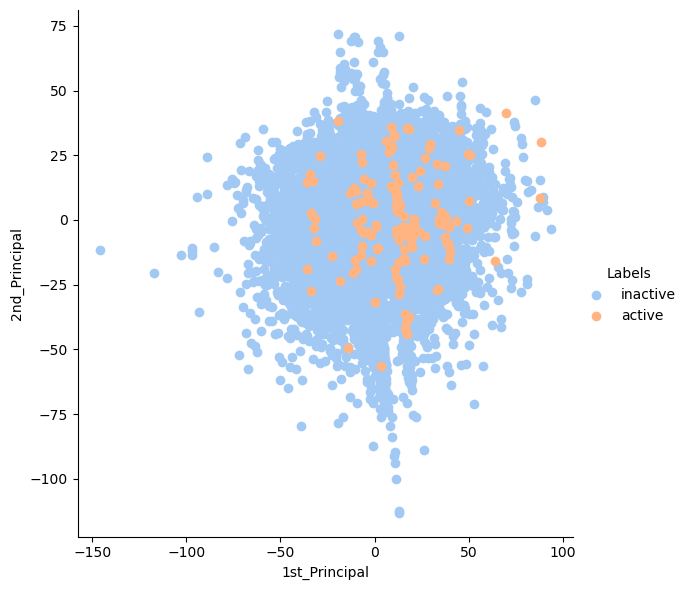

In [26]:
#fig, ax = plt.subplots()

scatter = sns.FacetGrid(df, palette='pastel', hue="Labels", height=6).map(plt.scatter, '1st_Principal', '2nd_Principal').add_legend()
#fig = plt.gcf()

# attempt 1 to hover-label points on plot with mpld3
#tooltip = mpld3.plugins.PointLabelTooltip(fig, labels=list(df.Labels))
#mpld3.plugins.connect(fig, tooltip)

#mpld3.display()

shape of the reduced PCA =  (16591, 2)


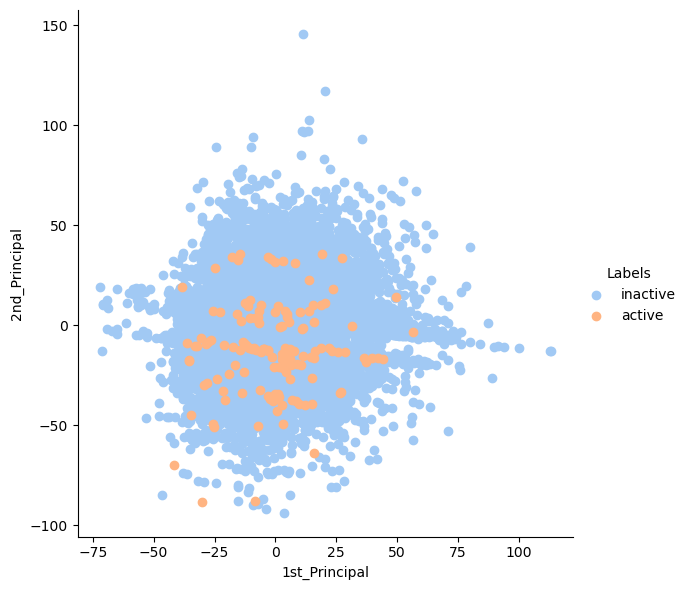

In [27]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(sample_data)

print("shape of the reduced PCA = ", pca_data.shape)
pca_data = np.vstack((pca_data.T, labels)).T

# new dataframe to plot the PCA results
pca_df = pd.DataFrame(pca_data, columns=("1st_Principal", "2nd_Principal", "Labels"))
sns.FacetGrid(pca_df, palette='pastel', hue="Labels", height=6).map(plt.scatter, '1st_Principal', '2nd_Principal').add_legend()
plt.show()

In [28]:
from sklearn.manifold import TSNE

C:\Users\17905\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\17905\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


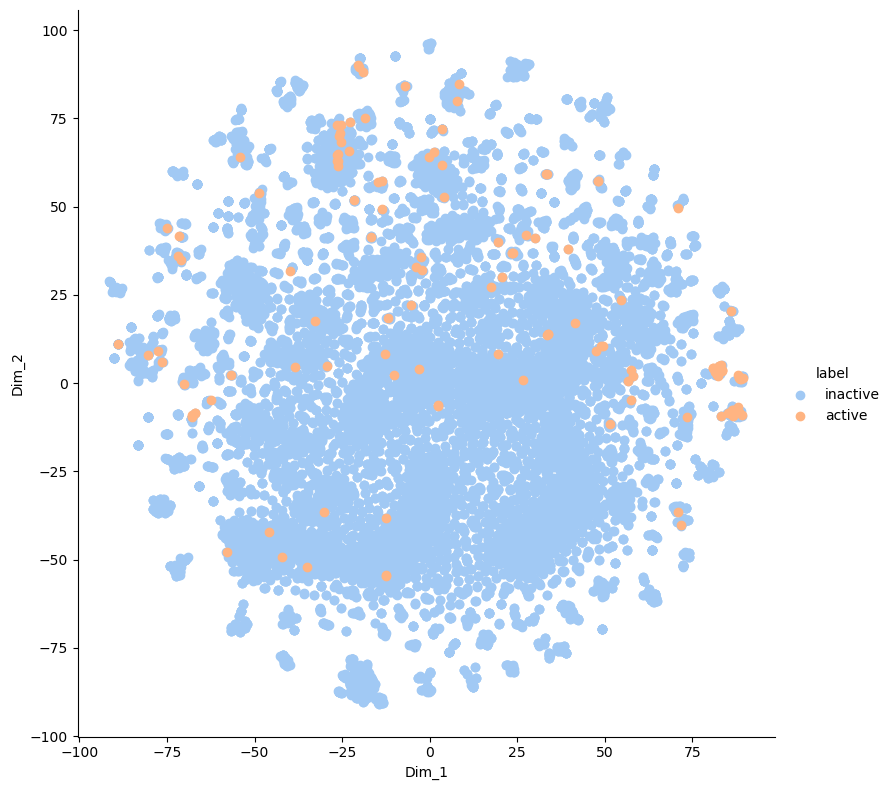

In [31]:
model = TSNE(n_components=2, random_state=420)
samples = standardized_m
# default perplexity = 30
# default epsilon (learning rate) = 200
# default Maximum number of iteration for the optimization = 1000

tsne_data = model.fit_transform(samples)

# new df to help plot resulting data
tsne_data = np.vstack((tsne_data.T, labels)).T # not really important to append the tags, just the labels for now
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

# plot resulting t-SNE model

sns.FacetGrid(tsne_df, palette='pastel', hue='label', height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

C:\Users\17905\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\17905\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


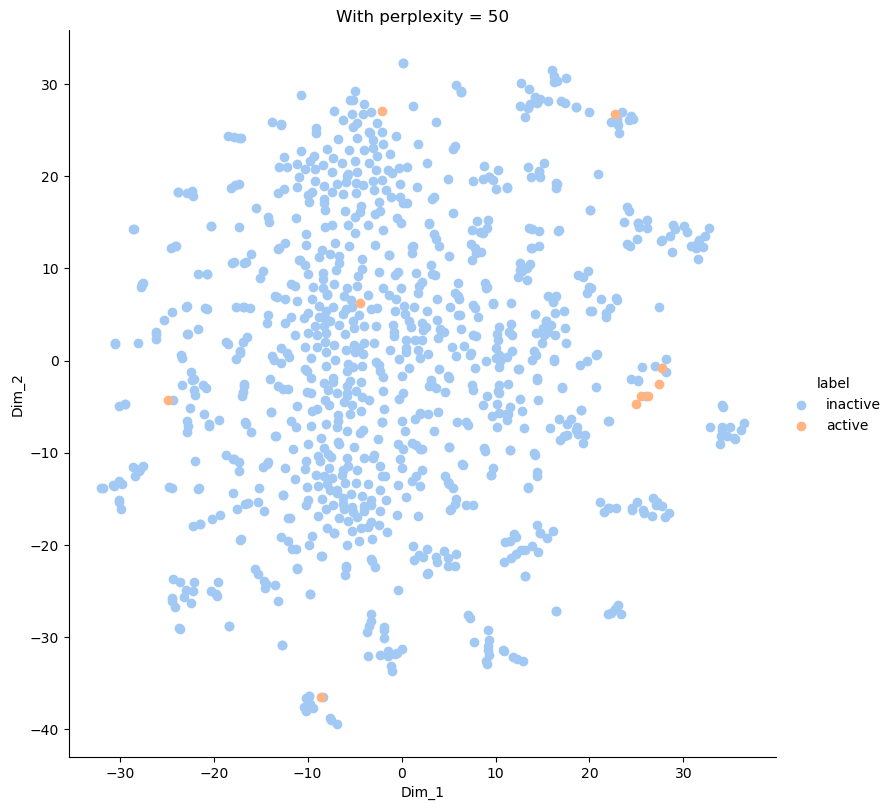

In [32]:
model = TSNE(n_components=2, random_state=420, perplexity=50) # try with top 1000 data points first

samples_1000 = standardized_m[0:1000,:]
labels_1000 = labels[0:1000]

tsne_data = model.fit_transform(samples_1000)

# new df to help plot resulting data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T # not really important to append the tags, just the labels for now
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

# plot resulting t-SNE model

sns.FacetGrid(tsne_df, palette='pastel', hue='label', height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

C:\Users\17905\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\17905\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


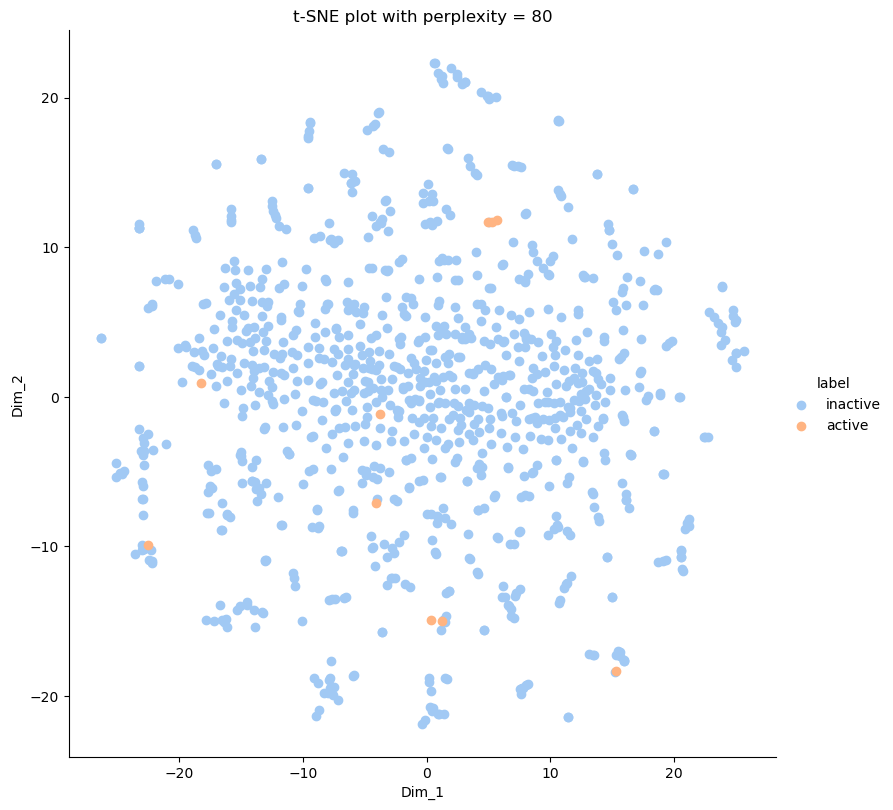

In [33]:
model = TSNE(n_components=2, random_state=420, perplexity=80) # try with top 1000 data points first

samples_1000 = standardized_m[0:1000,:]
labels_1000 = labels[0:1000]

tsne_data = model.fit_transform(samples_1000)

# new df to help plot resulting data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T 
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

# plot resulting t-SNE model

sns.FacetGrid(tsne_df, palette='pastel', hue='label', height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE plot with perplexity = 80')
plt.show()